In [1]:
# For importing utils
import sys
sys.path.append("..")


In [ ]:
PERTURBATIONS = {
    "en_30000": {"color": "#ADD8E6"},  # Light Blue
    "en_40000": {"color": "#87CEEB"},  # Sky Blue
    "en_50000": {"color": "#5F9EA0"},  # Cadet Blue
    "en_60000": {"color": "#4682B4"},  # Steel Blue
    "en_70000": {"color": "#4169E1"},  # Royal Blue
    "en_80000": {"color": "#000080"},  # Navy

    "de_30000": {"color": "#FFDAB9"},  # Peach Puff
    "de_40000": {"color": "#FFA07A"},  # Light Salmon
    "de_50000": {"color": "#FF6347"},  # Tomato
    "de_60000": {"color": "#FF4500"},  # Orange Red
    "de_70000": {"color": "#FF8C00"},  # Dark Orange
    "de_80000": {"color": "#8B0000"},  # Dark Red

    "ru_30000": {"color": "#2E0854"},  # Lavender
    "ru_40000": {"color": "#9370DB"},  # Medium Purple
    "ru_50000": {"color": "#7B68EE"},  # Medium Slate Blue
    "ru_60000": {"color": "#6A5ACD"},  # Slate Blue
    "ru_70000": {"color": "#4B0082"},  # Indigo
    "ru_80000": {"color": "#E6E6FA"},  # Midnight Purple

    "ro_30000": {"color": "#800080"},  # Misty Rose
    "ro_40000": {"color": "#FFB6C1"},  # Light Pink
    "ro_50000": {"color": "#FF69B4"},  # Hot Pink
    "ro_60000": {"color": "#DB7093"},  # Pale Violet Red
    "ro_70000": {"color": "#C71585"},  # Medium Violet Red
    "ro_80000": {"color": "#FFE4E1"},  # Purple

    "tr_30000": {"color": "#98FB98"},  # Pale Green
    "tr_40000": {"color": "#90EE90"},  # Light Green
    "tr_50000": {"color": "#32CD32"},  # Lime Green
    "tr_60000": {"color": "#228B22"},  # Forest Green
    "tr_70000": {"color": "#006400"},  # Dark Green
    "tr_80000": {"color": "#013220"},  # Very Dark Green
     "tr_pretrain": {"color": "#90EE90"},
}

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
def plot_geometric_mean_perplexities(ax_i, ax, file_info, title, checkpoints, seeds, merge, pos_encodings, warmup):
    
    nps = "" if pos_encodings else "_no_positional_encodings"
    wp = "_warmup" if warmup else ""

    results_path = '/Users/xiulinyang/Desktop/test/mission-impossible-language-models/perplexities/perplexity_results/shuffle_control_{}_{}/randinit_seed{}_test_shuffle_control_{}_{}.csv'
    average_values = {}
    for file_data in file_info:
        lang, lang2, vocab_size, marker, linestyle, legend_name= file_data

        all_seeds_gmeans = []
        for seed in seeds:
            df = pd.read_csv(results_path.format(lang, lang2, seed, lang, vocab_size),lineterminator='\n')
            gmeans = []
            min_means = []
            # Calculate geometric means for each checkpoint
            for ckpt in checkpoints:
                gmeans.append(stats.gmean(df[f"Perplexities (ckpt {ckpt})"]))
                min_means.append(stats.gmean(df[f"Perplexities (ckpt {ckpt})"]))
                
            if merge:
                gmeans = [min(min_means)]
            all_seeds_gmeans.append(gmeans)

        all_seeds_gmeans = np.array(all_seeds_gmeans)
        means = np.mean(all_seeds_gmeans, axis=0)
        # ci = None
        # if len(seeds) > 1:
        #     sems = stats.sem(all_seeds_gmeans, axis=0)
        #     # Calculate confidence interval using t-distribution
        #     ci_lower, ci_upper = stats.t.interval(0.95, df=len(seeds)-1,
        #                                         loc=means, scale=sems)
        #     ci = (ci_upper - ci_lower) / 2

        #     ax.errorbar(checkpoints, means, ci, marker=marker, 
        #                 color=PERTURBATIONS[f'{lang}_{vocab_size}']["color"],
        #                 linestyle=linestyle, label=legend_name)
        # if len(seeds) > 1:
            # Calculate the 25th and 75th percentiles (quartiles)
        lower_percentile = np.percentile(all_seeds_gmeans, 25, axis=0)
        upper_percentile = np.percentile(all_seeds_gmeans, 75, axis=0)
        
        # Calculate the error bars as the difference between the percentiles
        iqr_lower = means - lower_percentile  # Lower quartile error
        iqr_upper = upper_percentile - means  # Upper quartile error
        ax.errorbar(checkpoints, means, yerr=[iqr_lower, iqr_upper], marker=marker, markersize=4, linewidth=0.8,
                    color=PERTURBATIONS[f'{lang}_{vocab_size}']["color"],
                    linestyle=linestyle, label=legend_name)

            
        ax.set_title(title)
        if ax_i == 0:
            ax.set_ylabel("Geometric Mean Perplexity", fontsize=12)
        
        if not pos_encodings and title == "*Shuffle":
            ax.legend(fontsize=6)
        elif title == "*Shuffle":
            ax.legend(fontsize=8, framealpha=1)
        else:
            ax.legend(fontsize=8, framealpha=1)
        ax.grid(True, color="lightgray")
    # if merge:
    #     return average_values

In [ ]:
def plot_perplexities_grouped(file_infos, titles, checkpoints, seeds, merge=False, pos_encodings=True, warmup=False):
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 3, figsize=(16, 3*2), sharey=False, sharex=True)
    fig.subplots_adjust(wspace=0.15)
    fig.supxlabel("Training Steps", fontsize=12)

    # Flatten axs to handle cases with multiple rows, or wrap in a list for single subplot
    axs_flat = [axs] if len(file_infos) == 1 else axs.flatten()

    # Call individual plot function with different parameters for each subplot
    for i, (file_info, title) in enumerate(zip(file_infos, titles)):
        plot_geometric_mean_perplexities(
            i, axs_flat[i], file_info, title, checkpoints, seeds, merge, pos_encodings, warmup
        )

    # Turn off unused subplots
    for ax in axs_flat[len(file_infos):]:
        ax.axis("off")  # Hide extra plots

    plt.tight_layout()
    plt.savefig("tokenization_results.pdf", format="pdf", bbox_inches="tight")  # Save first
    plt.show()  # Then show

In [ ]:
def plot_perplexities_grouped_merge(file_infos, titles, checkpoints, seeds, merge=True, pos_encodings=True, warmup=False):
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(1, len(file_infos), figsize=(16, 5), sharey=False, sharex=True)
    fig.subplots_adjust(wspace=0.15)
    fig.supxlabel("Training Steps", fontsize=12)
    
    # axs_flat = axs.flatten()
    axs_flat = [axs] if len(file_infos) == 1 else axs.flatten()
    all_vas = []
    # Call individual plot function with different parameters for each subplot
    for i, (file_info, title) in enumerate(zip(file_infos, titles)):
        average_vas = plot_geometric_mean_perplexities(
            i, axs_flat[i], file_info, title, checkpoints, seeds, merge, pos_encodings, warmup)
        all_vas.append(average_vas)
    return all_vas

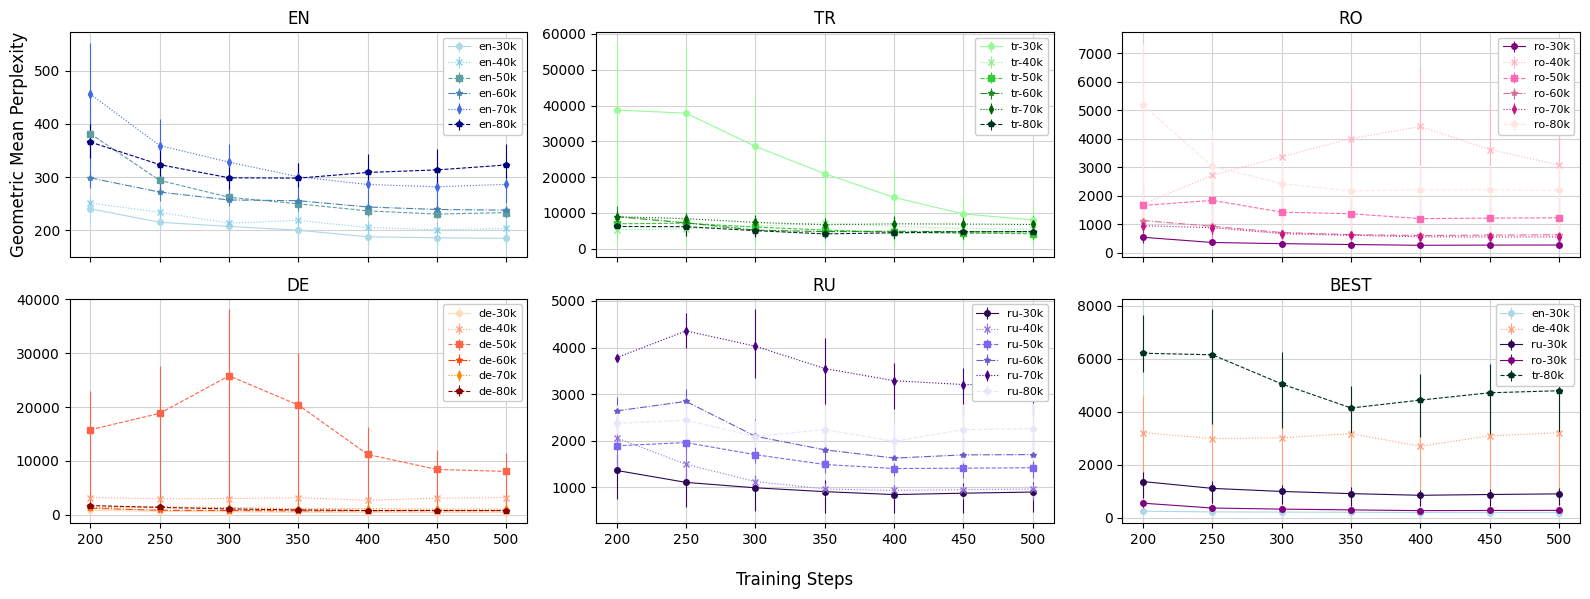

In [ ]:
MAX_TRAINING_STEPS = 500
CHECKPOINTS = list(range(200, MAX_TRAINING_STEPS+1, 50))
SEEDS = [42,76,81]
# SEEDS = [53]


# Consistent markers for data sizes
marker_info = {
    "30k": 'o',
    "40k": 'x',
    "50k": 's',
    "60k": '*',
    "70k": 'd',
    "80k": 'p'
}

en_info = [
    ("en", "EN", "30000", marker_info["30k"], "-", 'en-30k'),  # Dodger Blue
    ("en", "EN", "40000", marker_info["40k"], ":", 'en-40k'),  # Steel Blue
    ("en", "EN", "50000", marker_info["50k"], "--", 'en-50k'),  # Cadet Blue
    ("en", "EN", "60000", marker_info["60k"], "-.", 'en-60k'),  # New
    ("en", "EN", "70000", marker_info["70k"], ":", 'en-70k'),  # New
    ("en", "EN", "80000", marker_info["80k"], "--", 'en-80k'),  # New
]

de_info = [
    ("de", "DE", "30000", marker_info["30k"], "-", 'de-30k'),  # Orange-Red
    ("de", "DE", "40000", marker_info["40k"], ":", 'de-40k'),  # Tomato
    ("de", "DE", "50000", marker_info["50k"], "--", 'de-50k'),  # Light Salmon
    ("de", "DE", "60000", marker_info["60k"], "-.", 'de-60k'),  # New
    ("de", "DE", "70000", marker_info["70k"], ":", 'de-70k'),  # New
    ("de", "DE", "80000", marker_info["80k"], "--", 'de-80k'),  # New
]

ru_info = [
    ("ru", "RU", "30000", marker_info["30k"], "-", 'ru-30k'),  # Slate Blue
    ("ru", "RU", "40000", marker_info["40k"], ":", 'ru-40k'),  # Medium Purple
    ("ru", "RU", "50000", marker_info["50k"], "--", 'ru-50k'),  # Blue Violet
    ("ru", "RU", "60000", marker_info["60k"], "-.", 'ru-60k'),  # New
    ("ru", "RU", "70000", marker_info["70k"], ":", 'ru-70k'),  # New
    ("ru", "RU", "80000", marker_info["80k"], "--", 'ru-80k'),  # New
]

ro_info = [
    ("ro", "RO", "30000", marker_info["30k"], "-", 'ro-30k'),  # Medium Orchid
    ("ro", "RO", "40000", marker_info["40k"], ":", 'ro-40k'),  # Orchid
    ("ro", "RO", "50000", marker_info["50k"], "--", 'ro-50k'),  # Thistle
    ("ro", "RO", "60000", marker_info["60k"], "-.", 'ro-60k'),  # New
    ("ro", "RO", "70000", marker_info["70k"], ":", 'ro-70k'),  # New
    ("ro", "RO", "80000", marker_info["80k"], "--", 'ro-80k'),  # New
]

tr_info = [
    ("tr", "TR", "30000", marker_info["30k"], "-", 'tr-30k'),  # Forest Green
    ("tr", "TR", "40000", marker_info["40k"], ":", 'tr-40k'),  # Lime Green
    ("tr", "TR", "50000", marker_info["50k"], "--", 'tr-50k'),  # Lawn Green
    ("tr", "TR", "60000", marker_info["60k"], "-.", 'tr-60k'),  # New
    ("tr", "TR", "70000", marker_info["70k"], ":", 'tr-70k'),  # New
    ("tr", "TR", "80000", marker_info["80k"], "--", 'tr-80k'),  # New
    # ("tr", "TR", "pretrain", marker_info["80k"], "--", 'tr-pretrain'),  # New
]

multilingual_info =[("en", "EN", "30000", marker_info["30k"], "-", 'en-30k'),  # Dodger Blue
 ("de", "DE", "40000", marker_info["40k"], ":", 'de-40k'),  # Tomato
 ("ru", "RU", "30000", marker_info["30k"], "-", 'ru-30k'),  # Slate Blue
 ("ro", "RO", "30000", marker_info["30k"], "-", 'ro-30k'),  # Medium Orchid
 ("tr", "TR", "80000", marker_info["80k"], "--", 'tr-80k'),  # New
]


plot_perplexities_grouped([en_info, tr_info, ro_info, de_info, ru_info, multilingual_info],['EN', 'TR', 'RO', 'DE', 'RU', 'BEST'], CHECKPOINTS, SEEDS)
# plt.savefig("tokenization_results.pdf", format="pdf", bbox_inches="tight")

Plot saved as multilingual.pdf


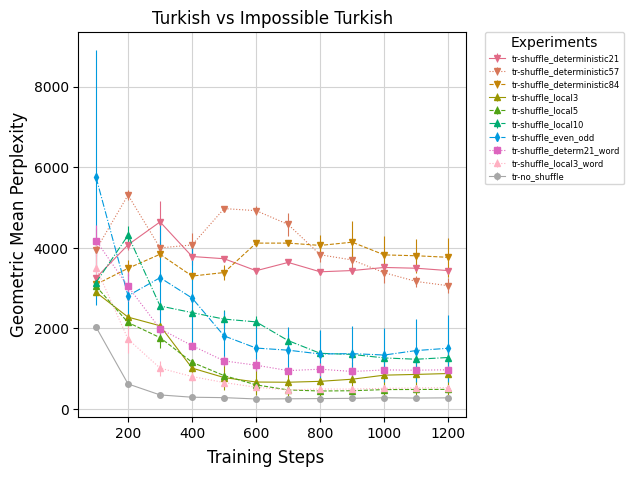

In [ ]:
tr_info = [
    # Turkish (tr) - Deterministic Shuffles
    ("tr", "TR", "shuffle_deterministic21", "v", "-", 'tr-shuffle_deterministic21'),  # Down Triangle, Solid
    ("tr", "TR", "shuffle_deterministic57", "v", ":", 'tr-shuffle_deterministic57'),  # Down Triangle, Dotted
    ("tr", "TR", "shuffle_deterministic84", "v", "--", 'tr-shuffle_deterministic84'),  # Down Triangle, Dashed

    # Turkish (tr) - Local Shuffles
    ("tr", "TR", "shuffle_local3", "^", "-", 'tr-shuffle_local3'),  # Up Triangle, Solid
    ("tr", "TR", "shuffle_local5", "^", "--", 'tr-shuffle_local5'),  # Up Triangle, Dashed
    ("tr", "TR", "shuffle_local10", "^", "-.", 'tr-shuffle_local10'),  # Up Triangle, Dash-Dot
    ("tr", "TR", "shuffle_even_odd", "d", "-.", 'tr-shuffle_even_odd'),  # Diamond, Dash-Dot
   
    # Turkish (tr) - Nondeterministic and Even-Odd

    ("tr", "TR", "shuffle_deterministic21_word", "s", ":", 'tr-shuffle_determ21_word'),  # Square, Dotted
        ("tr", "TR", "shuffle_local3_word", "^", ":", 'tr-shuffle_local3_word'),  # Up Triangle, Dotted
     ("tr", "TR", "shuffle_control", "o", "-", 'tr-no_shuffle'),  # Circle, Solid
    
]
SEEDS = [53,41]  # Single seed case
CHECKPOINTS = list(range(100, 1200+1, 100))
PERTURBATIONS_tr = {
    # Red Tones
    "shuffle_deterministic21": {"color": "#E16A86"},  # Light Red
    "huffle_deterministic57": {"color": "#D77658"},  # Soft Salmon Pink

    "shuffle_deterministic84": {"color": "#C48407"},  # Light Apricot Orange
    "shuffle_local3": {"color": "#999600"},  # Soft Peach
    "shuffle_local5": {"color": "#50A315"},  # Soft Pastel Yellow
    "shuffle_local10": {"color": "#00AC71"},  # Soft Pastel Green
    "shuffle_even_odd": {"color": "#009ADE"},  # Soft Light Blue
     "shuffle_control": {"color": "#A7A7A7"},
  
    "shuffle_deterministic21_word": {"color": "#DD64BE"}, 
    "shuffle_local3_word": {"color": "#FFB0C2"},

}
plot_perplexities_multilingual(tr_info, "Turkish vs Impossible Turkish", CHECKPOINTS, SEEDS, PERTURBATIONS_tr, 'tr.pdf')


Found existing installation: numpy 2.0.1
Uninstalling numpy-2.0.1:
  Would remove:
    /opt/anaconda3/envs/mission/bin/f2py
    /opt/anaconda3/envs/mission/bin/numpy-config
    /opt/anaconda3/envs/mission/lib/python3.9/site-packages/numpy-2.0.1.dist-info/*
    /opt/anaconda3/envs/mission/lib/python3.9/site-packages/numpy/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


## Results with different warm-up hyperparameters

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import cm

# A gradient of 5 shades of blue
SEEDS = [41,53,81]  # Single seed case
CHECKPOINTS = list(range(300, 1200 + 1, 100))


titles = ["English", "German", "Turkish", "Italian", "Dutch","Chinese", "Arabic", "Polish", "Romanian", "Russian", "French", 'Portuguese']
ling_info = [
    # English (EN)
    [
    # ("en", "EN", "perturb_reverse_full_word", "*", "-", 'perturb_reverse_full_word'), 
    ("en", "EN", "shuffle_deterministic84", "v", "-", 'shuffle_deterministic84'),  # Down Triangle, Solid
    ("en", "EN", "shuffle_deterministic57", "v", ":", 'shuffle_deterministic57'),  # Down Triangle, Dotted
    ("en", "EN", "shuffle_deterministic21", "v", "--", 'shuffle_deterministic21'),  # Down Triangle, 
    ("en", "EN", "shuffle_local10", "^", "-.", 'shuffle_local10'),  # Up Triangle, Dash-Dot
    ("en", "EN", "shuffle_local5", "^", "--", 'shuffle_local5'),  
    ("en", "EN", "shuffle_local3", "^", "-", 'shuffle_local3'), 
    ("en", "EN", "shuffle_local2", "^", "-", 'shuffle_local2'),
    ("en", "EN", "shuffle_even_odd", "d", "-.", 'shuffle_even_odd'),
    ("en", "EN", "shuffle_control", "o", "-", 'no_shuffle')],  # Diamond, Dash-Dot

    [
    ("de", "DE", "perturb_reverse_full_word", "*", "-", 'perturb_reverse_full_word'), 
    ("de", "DE", "shuffle_deterministic84", "v", "-", 'de-shuffle_deterministic84'),
    ("de", "DE", "shuffle_deterministic57", "v", ":", 'de-shuffle_deterministic57'),
    ("de", "DE", "shuffle_deterministic21", "v", "--", 'de-shuffle_deterministic21'),
    ("de", "DE", "shuffle_local10", "^", "-.", 'de-shuffle_local10'),
    ("de", "DE", "shuffle_local5", "^", "--", 'de-shuffle_local5'),
    ("de", "DE", "shuffle_local3", "^", "-", 'de-shuffle_local3'),
    ("de", "DE", "shuffle_local2", "^", "-", 'de-shuffle_local2'),
    ("de", "DE", "shuffle_even_odd", "d", "-.", 'de-shuffle_even_odd'),
     ("de", "DE", "shuffle_control", "o", "-", 'de-no_shuffle'),],

    #
    # Turkish (TR)
    [
    ("tr", "TR", "perturb_reverse_full_word", "*", "-", 'perturb_reverse_full_word'), 
    ("tr", "TR", "shuffle_deterministic84", "v", "-", 'tr-shuffle_deterministic84'),
    ("tr", "TR", "shuffle_deterministic57", "v", ":", 'tr-shuffle_deterministic57'),
    ("tr", "TR", "shuffle_deterministic21", "v", "--", 'tr-shuffle_deterministic21'),
     ("tr", "TR", "shuffle_local10", "^", "-", 'tr-shuffle_local10'),
    ("tr", "TR", "shuffle_local5", "^", "-", 'tr-shuffle_local5'),
    ("tr", "TR", "shuffle_local3", "^", "-", 'tr-shuffle_local3'),
         ("tr", "TR", "shuffle_local2", "^", "-", 'tr-shuffle_local2'),
     ("tr", "TR", "shuffle_control", "o", "-", 'tr-no_shuffle'),],
    # # # Italian (IT)
   [
         ("it", "IT", "perturb_reverse_full_word", "*", "-", 'perturb_reverse_full_word'), 
       ("it", "IT", "shuffle_deterministic84", "v", "-", 'it-shuffle_deterministic84'),
    ("it", "IT", "shuffle_deterministic57", "v", ":", 'it-shuffle_deterministic57'),
    ("it", "IT", "shuffle_deterministic21", "v", "--", 'it-shuffle_deterministic21'),
    ("it", "IT", "shuffle_local10", "^", "-.", 'it-shuffle_local10'),
    ("it", "IT", "shuffle_local5", "^", "--", 'it-shuffle_local5'),
    ("it", "IT", "shuffle_local3", "^", "-", 'it-shuffle_local3'),
        ("it", "IT", "shuffle_local2", "^", "-", 'it-shuffle_local2'),
    ("it", "IT", "shuffle_even_odd", "d", "-.", 'it-shuffle_even_odd'),
    ("it", "IT", "shuffle_control", "o", "-", 'it-no_shuffle'),],


    # # Dutch (NL)
   [
         ("nl", "NL", "perturb_reverse_full_word", "*", "-", 'perturb_reverse_full_word'), 
       ("nl", "NL", "shuffle_deterministic84", "v", "-", 'nl-shuffle_deterministic84'),
    ("nl", "NL", "shuffle_deterministic57", "v", ":", 'nl-shuffle_deterministic57'),
    ("nl", "NL", "shuffle_deterministic21", "v", "--", 'nl-shuffle_deterministic21'),
    ("nl", "NL", "shuffle_local10", "^", "-.", 'nl-shuffle_local10'),
    ("nl", "NL", "shuffle_local5", "^", "--", 'nl-shuffle_local5'),
    ("nl", "NL", "shuffle_local3", "^", "-", 'nl-shuffle_local3'),
         # ("nl", "NL", "shuffle_local2", "^", "-", 'nl-shuffle_local2'),
    ("nl", "NL", "shuffle_even_odd", "d", "-.", 'nl-shuffle_even_odd'),
    ("nl", "NL", "shuffle_control", "o", "-", 'nl-no_shuffle'),],


    # # # # Chinese (ZH)
    [
          # ("zh", "ZH", "perturb_reverse_full_word", "*", "-", 'perturb_reverse_full_word'), 
        ("zh", "ZH", "shuffle_deterministic84", "v", "-", 'zh-shuffle_deterministic84'),
    ("zh", "ZH", "shuffle_deterministic57", "v", ":", 'zh-shuffle_deterministic57'),
    ("zh", "ZH", "shuffle_deterministic21", "v", "--", 'zh-shuffle_deterministic21'),
    ("zh", "ZH", "shuffle_local10", "^", "-.", 'zh-shuffle_local10'),
    ("zh", "ZH", "shuffle_local5", "^", "--", 'zh-shuffle_local5'),
    ("zh", "ZH", "shuffle_local3", "^", "-", 'zh-shuffle_local3'),
            # ("zh", "ZH", "shuffle_local2", "^", "-", 'zh-shuffle_local2'),
    ("zh", "ZH", "shuffle_even_odd", "d", "-.", 'zh-shuffle_even_odd'),
     ("zh", "ZH", "shuffle_control", "o", "-", 'zh-no_shuffle'),],
    
    [
          ("ar", "AR", "perturb_reverse_full_word", "*", "-", 'perturb_reverse_full_word'), 
        ("ar", "AR", "shuffle_deterministic84", "v", "-", 'ar-shuffle_deterministic84'),
    ("ar", "AR", "shuffle_deterministic57", "v", ":", 'ar-shuffle_deterministic57'),
    ("ar", "AR", "shuffle_deterministic21", "v", "--", 'ar-shuffle_deterministic21'),
    ("ar", "AR", "shuffle_local10", "^", "-.", 'ar-shuffle_local10'),
    ("ar", "AR", "shuffle_local5", "^", "--", 'ar-shuffle_local5'),
    ("ar", "AR", "shuffle_local3", "^", "-", 'ar-shuffle_local3'),
           ("ar", "AR", "shuffle_local2", "^", "-", 'ar-shuffle_local2'),
    ("ar", "AR", "shuffle_even_odd", "d", "-.", 'ar-shuffle_even_odd'),
     ("ar", "AR", "shuffle_control", "o", "-", 'ar-no_shuffle'),],
    
    
   [
         ("pl", "PL", "perturb_reverse_full_word", "*", "-", 'perturb_reverse_full_word'), 
       ("pl", "PL", "shuffle_deterministic84", "v", "-", 'pl-shuffle_deterministic84'),
    ("pl", "PL", "shuffle_deterministic57", "v", ":", 'pl-shuffle_deterministic57'),
    ("pl", "PL", "shuffle_deterministic21", "v", "--", 'pl-shuffle_deterministic21'),
    ("pl", "PL", "shuffle_local10", "^", "-.", 'pl-shuffle_local10'),
     ("pl", "PL", "shuffle_local5", "^", "--", 'pl-shuffle_local5'),
    ("pl", "PL", "shuffle_local3", "^", "-", 'pl-shuffle_local3'),
        # ("pl", "PL", "shuffle_local2", "^", "-", 'pl-shuffle_local2'),
    ("pl", "PL", "shuffle_even_odd", "d", "-.", 'pl-shuffle_even_odd'),
     ("pl", "PL", "shuffle_control", "o", "-", 'pl-no_shuffle')],

    # # # # Romanian (RO)
   [
         ("ro", "RO", "perturb_reverse_full_word", "*", "-", 'perturb_reverse_full_word'), 
       ("ro", "RO", "shuffle_deterministic84", "v", "-", 'ro-shuffle_deterministic84'),
    ("ro", "RO", "shuffle_deterministic57", "v", ":", 'ro-shuffle_deterministic57'),
    ("ro", "RO", "shuffle_deterministic21", "v", "--", 'ro-shuffle_deterministic21'),
    ("ro", "RO", "shuffle_local10", "^", "-.", 'ro-shuffle_local10'),
    ("ro", "RO", "shuffle_local5", "^", "--", 'ro-shuffle_local5'),
    ("ro", "RO", "shuffle_local3", "^", "-", 'ro-shuffle_local3'),
          ("ro", "RO", "shuffle_local2", "^", "-", 'ro-shuffle_local2'),
    ("ro", "RO", "shuffle_even_odd", "d", "-.", 'ro-shuffle_even_odd'),
    ("ro", "RO", "shuffle_control", "o", "-", 'ro-no_shuffle'),],

    # #
    # # # Russian (RU)
    [
          ("ru", "RU", "perturb_reverse_full_word", "*", "-", 'perturb_reverse_full_word'), 
        ("ru", "RU", "shuffle_deterministic84", "v", "-", 'ru-shuffle_deterministic84'),
    ("ru", "RU", "shuffle_deterministic57", "v", ":", 'ru-shuffle_deterministic57'),
    ("ru", "RU", "shuffle_deterministic21", "v", "--", 'ru-shuffle_deterministic21'), 
    ("ru", "RU", "shuffle_local10", "^", "-.", 'ru-shuffle_local10'),
           ("ru", "RU", "shuffle_local5", "^", "--", 'ru-shuffle_local5'),
        ("ru", "RU", "shuffle_local3", "^", "-", 'ru-shuffle_local3'),
           ("ru", "RU", "shuffle_local2", "^", "-", 'ru-shuffle_local2'),
    ("ru", "RU", "shuffle_even_odd", "d", "-.", 'ru-shuffle_even_odd'),
     ("ru", "RU", "shuffle_control", "o", "-", 'ru-no_shuffle'),],
    
[
      ("fr", "FR", "perturb_reverse_full_word", "*", "-", 'perturb_reverse_full_word'), 
    ("fr", "FR", "shuffle_deterministic84", "v", "-", 'fr-shuffle_deterministic84'),
    ("fr", "FR", "shuffle_deterministic57", "v", ":", 'fr-shuffle_deterministic57'),
    ("fr", "FR", "shuffle_deterministic21", "v", "--", 'fr-shuffle_deterministic21'),

   
    ("fr", "FR", "shuffle_local10", "^", "-.", 'fr-shuffle_local10'),
     ("fr", "FR", "shuffle_local5", "^", "--", 'fr-shuffle_local5'),
        ("fr", "FR", "shuffle_local3", "^", "-", 'fr-shuffle_local3'),
     ("fr", "FR", "shuffle_local2", "^", "--", 'fr-shuffle_local2'),
    ("fr", "FR", "shuffle_even_odd", "d", "-.", 'fr-shuffle_even_odd'),
     ("fr", "FR", "shuffle_control", "o", "-", 'fr-no_shuffle'),],
[
      ("pt", "PT", "perturb_reverse_full_word", "*", "-", 'perturb_reverse_full_word'), 
    # ("pt", "PT", "shuffle_deterministic84", "v", "-", 'pt-shuffle_deterministic84'),
    ("pt", "PT", "shuffle_deterministic57", "v", ":", 'pt-shuffle_deterministic57'),
    ("pt", "PT", "shuffle_deterministic21", "v", "--", 'pt-shuffle_deterministic21'),
    ("pt", "PT", "shuffle_local10", "^", "-.", 'pt-shuffle_local10'),
      ("pt", "PT", "shuffle_local5", "^", "--", 'pt-shuffle_local5'),
        ("pt", "PT", "shuffle_local3", "^", "-", 'pt-shuffle_local3'),
      ("pt", "PT", "shuffle_local2", "^", "--", 'pt-shuffle_local2'),
    ("pt", "PT", "shuffle_even_odd", "d", "-.", 'pt-shuffle_even_odd'),
     ("pt", "PT", "shuffle_control", "o", "-", 'pt-no_shuffle'),],
]


PERTURBATIONS = {
    "perturb_reverse_full_word":"#6F63BB",
    "shuffle_deterministic84": "#8A60B0",  
    "shuffle_deterministic57": "#C7519C",  
    "shuffle_deterministic21":"#D63A3A", 
    "shuffle_local10": "#FFBF50",
    "shuffle_local5": "#BCBD22", 
    "shuffle_local3": "#78A641", 
    "shuffle_local2": "#2CA030", 
    "shuffle_even_odd": "#12A2A8", 
     "shuffle_control": "#1F83B4"
}


def plot_mean_perplexities_multilingual(ax, file_info, title, checkpoints, seeds, PERTURBATION):
    results_path = 'perplexity_results/{}_{}/randinit_seed{}_test_{}_{}_pretrained.csv'
    
    for file_data in file_info:
        lang, lang2, permutation, marker, linestyle, legend_name = file_data
        all_seeds_gmeans = []
        print(file_data)

        for seed in seeds:
            df = pd.read_csv(results_path.format(permutation, lang2, seed, permutation, lang), lineterminator='\n')
            gmeans = [stats.gmean(df[f"Perplexities (ckpt {ckpt})"]) for ckpt in checkpoints]
            # for k, ckpt in enumerate(checkpoints):
                # print(legend_name, ckpt, gmeans[k])
            all_seeds_gmeans.append(gmeans)
        all_seeds_gmeans = np.array(all_seeds_gmeans)
        means = np.mean(all_seeds_gmeans, axis=0)

        if len(seeds) > 1:
            ci = stats.sem(all_seeds_gmeans, axis=0)
        else:
            ci = None  # No confidence interval for a single seed

        # if permutation =='shuffle_control':
        #     colorp = PERTURBATION[f'{permutation}'][lang2]
        # else:
        colorp = PERTURBATION[f'{permutation}']
        if ci is not None:
            ax.errorbar(checkpoints, means, yerr=ci, marker=marker, markersize=4, linewidth=0.8,
                        color= colorp,
                        linestyle=linestyle, label=legend_name)
        else:
            ax.plot(checkpoints, means, marker=marker, markersize=4, linewidth=0.8,
                    color=colorp,
                    linestyle=linestyle, label=legend_name)

        ax.set_title(title)
        ax.grid(True, color="lightgray")
        ax.legend(fontsize=5, framealpha=1)


def plot_perplexities_multilingual(file_infos, titles, checkpoints, seeds, PERTURBATIONS_m, output_name):
    # Create the figure and a single axis (axs)
    fig, axes = plt.subplots(3, 4, figsize=(15, 10)) 
    fig.subplots_adjust(wspace=0.15)
    fig.supylabel('Geometric Mean Perplexity', fontsize=18)
    fig.supxlabel("Training Steps", fontsize=18)
    axes = axes.flatten()
    # axes[11].remove()
    for i, (file_info, title) in enumerate(zip(file_infos, titles)):
        plot_mean_perplexities_multilingual(axes[i], file_info, title, checkpoints, seeds, PERTURBATIONS_m)
        axes[i].tick_params(axis='y', labelsize=6)
        axes[i].tick_params(axis='x', labelsize=6)
        axes[i].yaxis.get_offset_text().set_fontsize(2)  # Adjust the offset text font size
        axes[i].legend().set_visible(False)
        # axes[i].legend(title="Experiments", loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=6, ncol=2, borderaxespad=0.)
    handles, labels = axes[0].get_legend_handles_labels()  # Get legend info from the first plot
    fig.legend(handles, labels, title="Experiments", loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(labels), fontsize=8)
    plt.savefig(output_name, format="pdf", bbox_inches="tight")
    
    print(f"Plot saved as {output_name}.pdf")

    plt.show()


plot_perplexities_multilingual(ling_info, titles, CHECKPOINTS, SEEDS, PERTURBATIONS,
                               'single_LM.png')

('en', 'EN', 'shuffle_deterministic84', 'v', '-', 'shuffle_deterministic84')


ValueError: object __array__ method not producing an array

Error in callback <function _draw_all_if_interactive at 0x147785940> (for post_execute), with arguments args (),kwargs {}:


ValueError: object __array__ method not producing an array

ImportError: cannot import name 'ERR_IGNORE' from 'numpy.core.umath' (/opt/anaconda3/envs/mission/lib/python3.9/site-packages/numpy/core/umath.py)

<Figure size 1500x1000 with 12 Axes>

en-perturb_reverse_full_word 300 203.24967658015308
en-perturb_reverse_full_word 400 165.47232956623188
en-perturb_reverse_full_word 500 131.94109341862378
en-perturb_reverse_full_word 600 116.83039892443826
en-perturb_reverse_full_word 700 105.60339650716708
en-perturb_reverse_full_word 800 102.3153596974823
en-perturb_reverse_full_word 900 100.85673402737977
en-perturb_reverse_full_word 1000 101.21839274889437
en-perturb_reverse_full_word 1100 99.3144545178062
en-perturb_reverse_full_word 1200 99.71862914761343
en-perturb_reverse_full_word 300 223.03236350471755
en-perturb_reverse_full_word 400 198.3632076627936
en-perturb_reverse_full_word 500 149.70712866438555
en-perturb_reverse_full_word 600 130.93364316953495
en-perturb_reverse_full_word 700 122.14584308289746
en-perturb_reverse_full_word 800 116.35368366334185
en-perturb_reverse_full_word 900 118.118895262353
en-perturb_reverse_full_word 1000 121.28538150277642
en-perturb_reverse_full_word 1100 121.43080866256949
en-perturb_rev

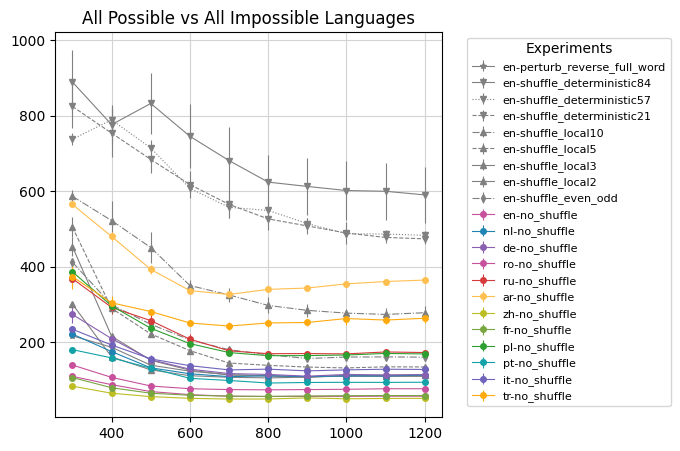

In [183]:
def plot_perplexities_single(file_infos, title, checkpoints, seeds, color, output_name):
    # Create the figure and a single axis (axs)
    fig, ax = plt.subplots(figsize=(5, 5)) 
    plot_mean_perplexities_multilingual(ax, file_infos, title, checkpoints, seeds, color)
    ax.legend(title="Experiments", loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8)
    plt.savefig(output_name, format="pdf", bbox_inches="tight")
    print(f"Plot saved as {output_name}.pdf")

    plt.show()
test_impossible =[
    ("en", "EN", "perturb_reverse_full_word", "*", "-", 'en-perturb_reverse_full_word'), 
    ("en", "EN", "shuffle_deterministic84", "v", "-", 'en-shuffle_deterministic84'),  # Down Triangle, Solid
    ("en", "EN", "shuffle_deterministic57", "v", ":", 'en-shuffle_deterministic57'),  # Down Triangle, Dotted
    ("en", "EN", "shuffle_deterministic21", "v", "--", 'en-shuffle_deterministic21'),  # Down Triangle, Dashed
    ("en", "EN", "shuffle_local10", "^", "-.", 'en-shuffle_local10'),  # Up Triangle, Dash-Dot
    ("en", "EN", "shuffle_local5", "^", "--", 'en-shuffle_local5'),  
    ("en", "EN", "shuffle_local3", "^", "-", 'en-shuffle_local3'), 
    ("en", "EN", "shuffle_local2", "^", "-", 'en-shuffle_local2'),
    ("en", "EN", "shuffle_even_odd", "d", "-.", 'en-shuffle_even_odd'),
     ("en", "EN", "shuffle_control", "o", "-", 'en-no_shuffle'),
     ('nl', 'NL', 'shuffle_control', 'o', '-', 'nl-no_shuffle'),  
('de', 'DE', 'shuffle_control', 'o', '-', 'de-no_shuffle'),  
('ro', 'RO', 'shuffle_control', 'o', '-', 'ro-no_shuffle'),  
('ru', 'RU', 'shuffle_control', 'o', '-', 'ru-no_shuffle'),  
('ar', 'AR', 'shuffle_control', 'o', '-', 'ar-no_shuffle'),  
('zh', 'ZH', 'shuffle_control', 'o', '-', 'zh-no_shuffle'),  
('fr', 'FR', 'shuffle_control', 'o', '-', 'fr-no_shuffle'),  
('pl', 'PL', 'shuffle_control', 'o', '-', 'pl-no_shuffle'),  
('pt', 'PT', 'shuffle_control', 'o', '-', 'pt-no_shuffle'),  
('it', 'IT', 'shuffle_control', 'o', '-', 'it-no_shuffle'),  
('tr', 'TR', 'shuffle_control', 'o', '-', 'tr-no_shuffle'),  
]

COLOR_all = {
    'en-no_shuffle' :'#C7519C',
    'nl-no_shuffle': '#1F83B4',
    'de-no_shuffle': '#8A60B0',
    'ro-no_shuffle': '#C7519C',
    'ru-no_shuffle': '#D63A3A',
     'tr-no_shuffle': '#FFAA0E',
    'ar-no_shuffle': '#FFBF50',
    'zh-no_shuffle': '#BCBD22',
    'fr-no_shuffle': '#78A641',
    'pl-no_shuffle': '#2CA030',
    'pt-no_shuffle': '#12A2A8',
    'it-no_shuffle': '#6F63BB',
    'en-perturb_reverse_full_word': '#808080',
    'en-shuffle_deterministic84': '#808080',
    'en-shuffle_deterministic57': '#808080',
    'en-shuffle_deterministic21': '#808080',
    'en-shuffle_local10': '#808080',
    'en-shuffle_local5': '#808080',
    'en-shuffle_local3': '#808080',
    'en-shuffle_local2': '#808080',
    'en-shuffle_even_odd': '#808080',
    'en-shuffle_control': '#808080',

}
title='All Possible vs All Impossible Languages'
plot_perplexities_single(test_impossible, title, CHECKPOINTS, SEEDS, COLOR_all,'more_specific.png')

In [11]:
SEEDS=[41]

CHECKPOINTS = list(range(300, 1200 + 1, 100))
en_impossible=[
# ("en", "EN", "perturb_adj_num_np_det", "d", "-.", 'en-perturb_adj_num_np_det',"perturb_adj_num_np_det",),
# # ("en", "EN", "perturb_adj_num_np_det", "d", "-.", 'en-no_shuffle-adj_num_np_det','shuffle_control'),
# ("en", "EN", "perturb_det_num_adj_np", "d", "-.", 'en-perturb_det_num_adj_np','perturb_det_num_adj_np'),
# ("en", "EN", "perturb_det_num_np_adj", "d", "-.", 'en-perturb_det_num_np_adj', 'perturb_det_num_np_adj'),
# # ("en", "EN", "perturb_det_num_np_adj", "d", "-.", 'en-no_shuffle-det_num_np_adj','shuffle_control'),
# # ("en", "EN", "perturb_np_num_det_adj", "d", "-.", 'en-no_shuffle-np_num_det_adj','shuffle_control'),
# ("en", "EN", "perturb_np_num_det_adj", "d", "-.", 'en-perturb_np_num_det_adj','perturb_np_num_det_adj'),
# ("en", "EN", "perturb_det_adj_np_num", "d", "-.", 'en-perturb_det_adj_np_num','perturb_det_adj_np_num'),
# ("aann", "EN", "perturb_np_num_det_adj", "d", "-.", 'en-no_shuffle-np_num_det_adj','shuffle_control'),
# ("nnda", "EN", "perturb_np_num_det_adj", "d", "-.", 'en-perturb_reverse_full_word','shuffle_control'),

# ("en", "EN", "perturb_np_num_det_adj", "d", "-.", 'en-perturb_np_num_det_adj','perturb_np_num_det_adj'),
# ("en", "EN", "perturb_det_adj_np_num", "d", "-.", 'en-no_shuffle-det_adj_np_num','shuffle_control'),
# 
("it", "IT", "shuffle_local3", "^", "-", 'it-shuffle_local3',"shuffle_local3"),
("it", "IT", "shuffle_local2", "^", "-", 'it-shuffle_local2', "shuffle_local2"),
("it", "IT", "shuffle_control", "o", "-", 'it-no_shuffle','shuffle_control'),
("it", "IT", "perturb_reverse_full_word", "*", "-.", 'it-perturb_reverse_full_word',"perturb_reverse_full_word"),
("itrn", "ITRN", "shuffle_control", "o", "-", 'it-np-shuffle-random','shuffle_control'),
    ("it", "IT", "perturb_adj_num_np_det", "d", "-.", 'it-perturb_adj_num_np_det',"perturb_adj_num_np_det",),
# ("en", "IT", "perturb_adj_num_np_det", "d", "-.", 'en-no_shuffle-adj_num_np_det','shuffle_control'),
("it", "IT", "perturb_det_num_adj_np", "d", "-.", 'it-perturb_det_num_adj_np','perturb_det_num_adj_np'),
("it", "IT", "perturb_det_num_np_adj", "d", "-.", 'it-perturb_det_num_np_adj', 'perturb_det_num_np_adj'),
# ("en", "IT", "perturb_det_num_np_adj", "d", "-.", 'en-no_shuffle-det_num_np_adj','shuffle_control'),
# ("en", "IT", "perturb_np_num_det_adj", "d", "-.", 'en-no_shuffle-np_num_det_adj','shuffle_control'),
("it", "IT", "perturb_np_num_det_adj", "d", "-.", 'it-perturb_np_num_det_adj','perturb_np_num_det_adj'),
("it", "IT", "perturb_det_adj_np_num", "d", "-.", 'it-perturb_det_adj_np_num','perturb_det_adj_np_num'),

# ("en", "EN", "shuffle_local2", "^", "-", 'en-shuffle_local2'),
# ("tr", "TR", "perturb_reverse_full_word", "d", "-.", 'tr-perturb_reverse_full_word'),
]

'''  "en-no_shuffle-det_num_np_adj": "#495057",
    "en-no_shuffle-det_adj_np_num": "#a2d6f9",
    "en-no_shuffle-np_num_det_adj": "#52b788",
    "en-no_shuffle-adj_num_np_det": "#52b788",'''

COLOR = {
    
    "it-shuffle_local3" :"#52b788",
    "it-shuffle_local2": "#7b2cbf", 
    "it-perturb_reverse_full_word": "#c77dff", 
    "it-np-shuffle-random":"#a2d6f9",
    "it-no_shuffle": "#A2B627",
    "it-perturb_adj_num_np_det":"#ff8800" ,
    "it-perturb_det_num_np_adj":"#ffaa00",
    "it-perturb_np_num_det_adj": "#f1db33" ,
    "it-perturb_det_adj_np_num": "#dfab06",
    "it-perturb_det_num_adj_np": "#da6220",
}
title = ''
def plot_mean_perplexities(ax, file_info, title, checkpoints, seeds, PERTURBATION):
    results_path = 'perplexity_results/{}_{}/randinit_seed{}_test_{}_{}_pretrained.csv'

    for file_data in file_info:
        lang, lang2, permutation, marker, linestyle, legend_name, test_pert = file_data
        all_seeds_gmeans = []

        for seed in seeds:
            df = pd.read_csv(results_path.format(permutation, lang2, seed, test_pert, lang), lineterminator='\n')
            gmeans = [stats.gmean(df[f"Perplexities (ckpt {ckpt})"]) for ckpt in checkpoints]
            for k, ckpt in enumerate(checkpoints):
                print(legend_name, ckpt, gmeans[k])
            all_seeds_gmeans.append(gmeans)
        all_seeds_gmeans = np.array(all_seeds_gmeans)
        means = np.mean(all_seeds_gmeans, axis=0)

        if len(seeds) > 1:
            ci = stats.sem(all_seeds_gmeans, axis=0)
        else:
            ci = None  # No confidence interval for a single seed
        colorp = PERTURBATION[f'{legend_name}']
        if ci is not None:
            ax.errorbar(checkpoints, means, yerr=ci, marker=marker, markersize=4, linewidth=0.8,
                        color= colorp,
                        linestyle=linestyle, label=legend_name)
        else:
            ax.plot(checkpoints, means, marker=marker, markersize=4, linewidth=0.8,
                    color=colorp,
                    linestyle=linestyle, label=legend_name)

        ax.set_title(title)
        ax.grid(True, color="lightgray")
        ax.legend(fontsize=5, framealpha=1)
        
        


def plot_perplexities_single(file_infos, title, checkpoints, seeds, color, output_name):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 5), gridspec_kw={'height_ratios': [1, 3]})  

    # Plot on both axes
    plot_mean_perplexities(ax1, file_infos, title, checkpoints, seeds, color)
    plot_mean_perplexities(ax2, file_infos, title, checkpoints, seeds, color)

    # Set different y-limits
    ax1.set_ylim(150, 500)  # Upper part of the y-axis (zoomed out)
    ax2.set_ylim(50, 150)     # Lower part of the y-axis (detailed view)

    # Hide spines between the two subplots
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')

    # Add diagonal lines to indicate break
    d = .015
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)  
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  
    ax1.legend().set_visible(False)
    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  
    ax2.legend().set_visible(False)
    ax2.set_ylabel("Geometric Mean Perplexity")
    ax2.set_xlabel("Training Steps")
    fig.suptitle(title)
    handles, labels = ax1.get_legend_handles_labels()  # Get legend from ax1
    
    fig.legend(handles, labels, title="Experiments", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

    # Save & show
    plt.savefig(output_name, format="pdf", bbox_inches="tight")
    plt.show()
    print(f"Plot saved as {output_name}.pdf")
    
plot_perplexities_single(en_impossible, title, CHECKPOINTS, SEEDS, COLOR,'sanity_check.pdf')

it-shuffle_local3 300 671.0859571047704
it-shuffle_local3 400 309.4461282695293
it-shuffle_local3 500 190.34163078338955
it-shuffle_local3 600 143.11659501748505
it-shuffle_local3 700 119.5639933879602
it-shuffle_local3 800 118.92696983639807
it-shuffle_local3 900 111.16075568795291
it-shuffle_local3 1000 114.40391518927963
it-shuffle_local3 1100 112.27404724055886
it-shuffle_local3 1200 112.00422709883802
it-shuffle_local2 300 444.01704228699856
it-shuffle_local2 400 174.63468863406538
it-shuffle_local2 500 123.84105867083056
it-shuffle_local2 600 114.79630698701018
it-shuffle_local2 700 111.75818703266565
it-shuffle_local2 800 116.35659390942376
it-shuffle_local2 900 117.39701322728303
it-shuffle_local2 1000 127.97790358618312
it-shuffle_local2 1100 138.01223570110906
it-shuffle_local2 1200 136.3845113607139
it-no_shuffle 300 239.31662876020823
it-no_shuffle 400 197.85633329269007
it-no_shuffle 500 160.890049046609
it-no_shuffle 600 141.58056910399822
it-no_shuffle 700 124.0199746568

FileNotFoundError: [Errno 2] No such file or directory: 'perplexity_results/shuffle_control_ITRN/randinit_seed41_test_shuffle_control_itrn_pretrained.csv'

Error in callback <function _draw_all_if_interactive at 0x147785940> (for post_execute), with arguments args (),kwargs {}:


ValueError: object __array__ method not producing an array

ImportError: cannot import name 'ERR_IGNORE' from 'numpy.core.umath' (/opt/anaconda3/envs/mission/lib/python3.9/site-packages/numpy/core/umath.py)

<Figure size 500x500 with 2 Axes>

In [ ]:
#     ("en", "EN", "perturb_adj_num", "d", "-.", 'en-perturb_adj_num'),
# ("en", "EN", "perturb_num_adj", "d", "-.", 'en-perturb_num_adj'),
# ("en", "EN", "perturb_np_num_det_adj", "d", "-.", 'en-perturb_np_num_det_adj'),
# ("en", "EN", "perturb_det_num_np_adj", "d", "-.", 'en-perturb_det_num_np_adj'),
# ("en", "EN", "perturb_adj_num_np_det", "d", "-.", 'en-perturb_adj_num_np_det'),


In [14]:

from glob import glob
import pandas as pd

CHECKPOINTS = list(range(0, 1200 + 1, 100))
perp_csv = sorted(glob('perplexity_results/**/*.csv', recursive=True))
with open('perplexity_results_new.csv', 'w') as res:
    header = ['lang', 'perturb', 'seed'] + [f'checkpoint{ckpt}' for ckpt in CHECKPOINTS]
    res.write(','.join(header) + '\n')
    for p in perp_csv:
        print(p)
        row = []
        seed = p.split('seed')[1].split('_')[0]
        lang = p.split('/')[-2].split('_')[-1]
        perturb = '_'.join(p.split('/')[-2].split('_')[:-1])
        row.extend([lang, perturb, seed])

        all_seeds_gmeans = []
        df = pd.read_csv(p, lineterminator='\n')
        gmeans = [stats.gmean(df[f"Perplexities (ckpt {ckpt})"]) for ckpt in CHECKPOINTS]
        row += gmeans
        res.write(','.join(map(str, row)) + '\n')



perplexity_results/perturb_adj_num_EN/randinit_seed41_test_perturb_adj_num_en_pretrained.csv
perplexity_results/perturb_adj_num_EN/randinit_seed53_test_perturb_adj_num_en_pretrained.csv
perplexity_results/perturb_adj_num_EN/randinit_seed81_test_perturb_adj_num_en_pretrained.csv
perplexity_results/perturb_adj_num_np_det_EN/randinit_seed41_test_perturb_adj_num_np_det_en_pretrained.csv
perplexity_results/perturb_adj_num_np_det_EN/randinit_seed41_test_shuffle_control_en_pretrained.csv
perplexity_results/perturb_adj_num_np_det_EN/randinit_seed53_test_perturb_adj_num_np_det_en_pretrained.csv
perplexity_results/perturb_adj_num_np_det_EN/randinit_seed53_test_shuffle_control_en_pretrained.csv
perplexity_results/perturb_adj_num_np_det_EN/randinit_seed81_test_perturb_adj_num_np_det_en_pretrained.csv
perplexity_results/perturb_adj_num_np_det_EN/randinit_seed81_test_shuffle_control_en_pretrained.csv
perplexity_results/perturb_adj_num_np_det_IT/randinit_seed41_test_perturb_adj_num_np_det_it_pretrain

/opt/anaconda3/envs/mission/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
/opt/anaconda3/envs/mission/lib/python3.9/site-packages/numpy/_core/_methods.py:140: RuntimeWarning: invalid value encountered in scalar divide


perplexity_results/perturb_np_num_det_adj_EN/randinit_seed41_test_shuffle_control_aann_pretrained.csv
perplexity_results/perturb_np_num_det_adj_EN/randinit_seed41_test_shuffle_control_en_pretrained.csv
perplexity_results/perturb_np_num_det_adj_EN/randinit_seed41_test_shuffle_control_nnda_pretrained.csv
perplexity_results/perturb_np_num_det_adj_EN/randinit_seed53_test_perturb_np_num_det_adj_en_pretrained.csv
perplexity_results/perturb_np_num_det_adj_EN/randinit_seed53_test_shuffle_control_aann_pretrained.csv
perplexity_results/perturb_np_num_det_adj_EN/randinit_seed53_test_shuffle_control_en_pretrained.csv
perplexity_results/perturb_np_num_det_adj_EN/randinit_seed53_test_shuffle_control_nnda_pretrained.csv
perplexity_results/perturb_np_num_det_adj_EN/randinit_seed81_test_perturb_np_num_det_adj_en_pretrained.csv
perplexity_results/perturb_np_num_det_adj_EN/randinit_seed81_test_shuffle_control_aann_pretrained.csv
perplexity_results/perturb_np_num_det_adj_EN/randinit_seed81_test_shuffle_co

In [21]:
import pandas as pd
results = pd.read_csv('perplexity_results.tsv', sep='\t')
filtered_df = results[results['lang'].str.contains('EN', na=False)]

In [22]:
filtered_df

,lang,perturb,seed,checkpoint300,checkpoint400,checkpoint500,checkpoint600,checkpoint700,checkpoint800,checkpoint900,checkpoint1000,checkpoint1100,checkpoint1200
0,EN,perturb_adj_num,41,134.008054,101.205637,80.959520,74.720295,71.209426,68.749459,73.383364,74.003967,74.728481,74.266071
1,EN,perturb_adj_num,53,132.881329,103.935464,83.222194,74.227846,72.379357,71.554424,69.388090,72.073594,73.801441,73.025624
2,EN,perturb_adj_num,81,132.685876,104.050662,81.748243,76.082681,71.597128,69.486812,73.197419,72.402923,73.740317,73.166646
3,EN,perturb_num_adj,41,133.129259,98.772430,84.122246,74.141843,71.208655,72.064083,73.759985,74.351478,75.922029,75.825711
4,EN,perturb_num_adj,53,130.052299,96.325463,77.405009,72.341117,71.244261,69.424073,69.986150,72.467309,73.484083,73.515599
5,EN,perturb_num_adj,81,131.846613,102.019319,83.755841,78.695752,74.515872,71.850545,74.678270,76.344902,74.370761,75.363028
9,EN,shuffle_control,41,133.542056,103.630330,84.216785,73.878906,70.883655,70.594945,70.040628,71.680532,73.185175,72.899238
10,EN,shuffle_control,53,133.956368,98.724627,81.972615,73.162305,72.006728,69.055918,70.310046,72.172636,72.216949,72.105843
11,EN,shuffle_control,81,134.047089,101.918351,81.240034,75.645622,70.680181,72.413382,69.628531,71.742825,73.019024,72.976955
36,EN,shuffle_deterministic21,41,912.423173,773.547858,723.109660,633.880311,564.218763,539.887679,509.293144,494.158141,493.200536,488.849456
